# 4. Сверточные нейронные сети.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г.

In [1]:
import typing as t
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("data/")
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR = Path("models/")
MODELS_DIR.mkdir(exist_ok=True)
COLAB_DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/ML")

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


In [ ]:
def is_colab() -> bool:
    return DEVICE == "cuda"

## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [6]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
])

train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

train_data.data.size(), train_data.targets.size(), len(train_data.classes)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



(torch.Size([60000, 28, 28]), torch.Size([60000]), 10)

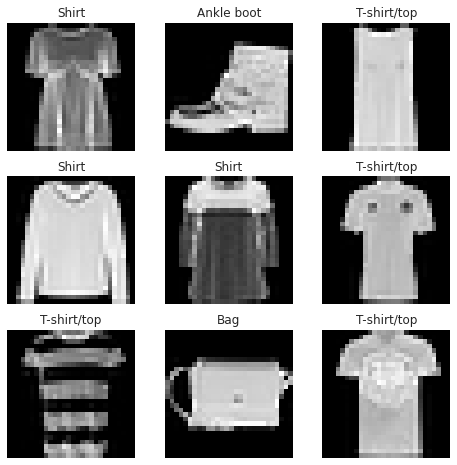

In [7]:
torch.manual_seed(0)

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

Архитектура модели взята из **[Introduction to PyTorch](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#define-the-class)**:

In [8]:
class FashionMNISTLogisticRegression(nn.Module):

    def __init__(self, in_features: int, out_features: int):
        super(FashionMNISTLogisticRegression, self).__init__()
        self.flatten = nn.Flatten()  # по умолчанию разворачивает все измерения начиная со 2-ого
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, n_channels * width * height)
        return self.classifier(x)

In [9]:
def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        pred = model(x)  # (batch_size, n_classes)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

    return avg_loss / num_batches


def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:  # умеет работать с batch'ами; в нашем случае batch один
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            avg_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy

Функция [потерь](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#loss-function) и [оптимизатор](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#optimizer) взяты из **Introduction to PyTorch**:

In [10]:
torch.manual_seed(0)

# количество входных параметров модели определяется как произведение:
# кол-во цветовых каналов * ширина картинки * высота картинки
net = FashionMNISTLogisticRegression(1 * 28 * 28, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

train_dataloader = DataLoader(
    train_data,
    batch_size=64,
    num_workers=2 if is_colab() else 0,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=len(test_data),
    num_workers=2 if is_colab() else 0,
)

net

FashionMNISTLogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Обучаем модель:

In [11]:
%%time

epochs = 10
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

Epoch 1
--------------------------------
loss: 2.299407  [    0/60000]
loss: 2.245826  [ 6400/60000]
loss: 2.148032  [12800/60000]
loss: 2.109230  [19200/60000]
loss: 1.964170  [25600/60000]
loss: 1.873128  [32000/60000]
loss: 1.765596  [38400/60000]
loss: 1.640909  [44800/60000]
loss: 1.568382  [51200/60000]
loss: 1.412620  [57600/60000]
Test Error: 
 Accuracy: 0.639700, Avg loss: 1.403269 

Epoch 2
--------------------------------
loss: 1.437996  [    0/60000]
loss: 1.420322  [ 6400/60000]
loss: 1.167585  [12800/60000]
loss: 1.301452  [19200/60000]
loss: 1.074438  [25600/60000]
loss: 1.099373  [32000/60000]
loss: 1.062042  [38400/60000]
loss: 1.011352  [44800/60000]
loss: 1.048614  [51200/60000]
loss: 0.958107  [57600/60000]
Test Error: 
 Accuracy: 0.719900, Avg loss: 0.933654 

Epoch 3
--------------------------------
loss: 0.948851  [    0/60000]
loss: 1.005085  [ 6400/60000]
loss: 0.747223  [12800/60000]
loss: 0.985312  [19200/60000]
loss: 0.843050  [25600/60000]
loss: 0.860392  [

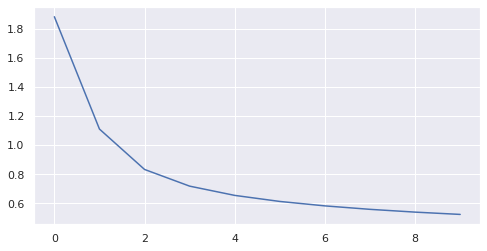

In [12]:
plt.plot(torch.arange(len(train_losses)), train_losses);

Пользуемся результатами обучения:

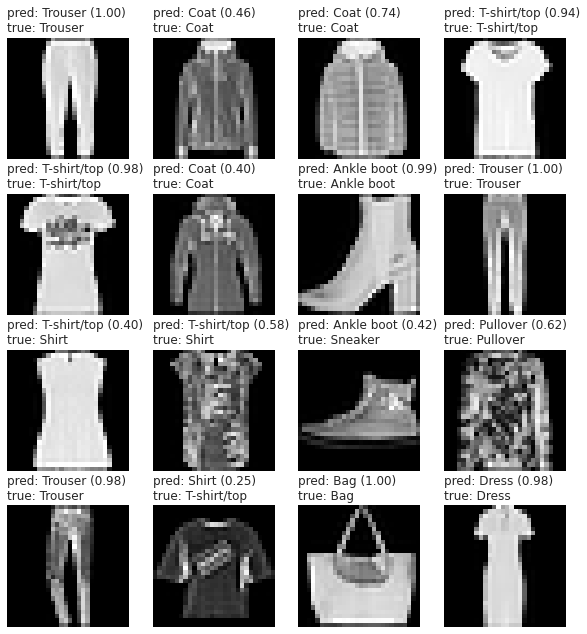

In [13]:
torch.manual_seed(0)
net.eval()

fig = plt.figure(figsize=(10, 11))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]
    img = img.to(DEVICE)

    pred = net(img.unsqueeze(0))
    pred_proba = F.softmax(pred, 1).max(1).values.item()  # насколько модель уверена в своем решении
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    plt.imshow(img.squeeze().cpu(), cmap="gray")

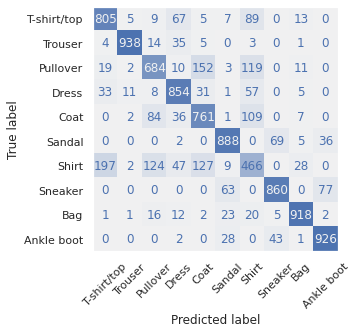

In [14]:
X_test, y_test = next(iter(test_dataloader))
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
pred_label = pred.argmax(dim=1)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.cpu(), pred_label.detach().cpu(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=sns.color_palette("light:b", as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [15]:
test_loop(test_dataloader, net, loss_fn);

Test Error: 
 Accuracy: 0.810000, Avg loss: 0.538824 



Сохраняем модель:

In [16]:
torch.save(net, MODELS_DIR / "FashionMNIST-log-reg.pth")

In [17]:
net = torch.load(MODELS_DIR / "FashionMNIST-log-reg.pth")
net.eval()

FashionMNISTLogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

Прежде чем работать дальше, ускорим загрузку данных:
- уберем ненужные преобразования (Tensor -> Image -> Tensor)
- сохраним преобразованный датасет
- сохраним результат работы Dataloader'а

In [18]:
class FastFashionMNSITDataset(Dataset):

    def __init__(self, dataset: datasets.FashionMNIST):
        self.dataset = dataset
        self.transform = self.dataset.transform

        self._data = self.dataset.data.to(torch.float32)
        if len(self._data.size()) == 3:  # [n_samples, width, height] -> [n_samples, n_channels, width, height]
            self._data = self._data.unsqueeze(1)

        self._targets = self.dataset.targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):  # избавимся от ненужных преобразований
        img, target = self._data[index], self._targets[index]
        if self.transform:
            img = self.transform(img)
        return img, target


class FastDataloader:

    def __init__(self, dataloader: DataLoader[Dataset], force: bool = False):
        self.dataloader = dataloader
        # кэш
        self._force = force
        self._bathes = [0] * len(self.dataloader)
        self._create_batches()

    @property
    def dataset(self):
        return self.dataloader.dataset

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        if self._force:
            self._create_batches()
        return self._get_iterator()

    def _create_batches(self):
        for i, batch in enumerate(self.dataloader):
            self._bathes[i] = batch

    def _get_iterator(self):
        for batch in self._bathes:
            yield batch

In [19]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

fast_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transforms.Compose([  # ToTensor() не нужно - уже Tensor
        transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
    ]),
)

slow_dataset = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
    ]),
)

In [20]:
%%time

slow_dataloader = DataLoader(
    slow_dataset,
    batch_size=4,
    num_workers=2 if is_colab() else 0,
)

for epoch in tqdm(range(40)):
    for x, y in slow_dataloader:
        pass

100%|██████████| 40/40 [21:33<00:00, 32.35s/it]

CPU times: user 7min 54s, sys: 2min 53s, total: 10min 47s
Wall time: 21min 33s


In [21]:
%%time

fast_dataset = FastFashionMNSITDataset(fast_data)
fast_dataloader = FastDataloader(DataLoader(
    fast_dataset,
    batch_size=4,
    num_workers=2 if is_colab() else 0,
))

for epoch in tqdm(range(40)):
    for x, y in fast_dataloader:
        pass

100%|██████████| 40/40 [00:00<00:00, 685.11it/s]

CPU times: user 11.7 s, sys: 4.25 s, total: 15.9 s
Wall time: 28.2 s


В 50 раз быстрее? А еще можно было сделать нормальное индексирование...

Архитектура модели (вдохновлялся `models.vgg16`):

In [22]:
class FashionMNISTConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(FashionMNISTConvNet, self).__init__()
        self.features = nn.Sequential(OrderedDict({
            "conv1": nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            "norm1": nn.BatchNorm2d(32),
            "relu1": nn.ReLU(True),
            "maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            "norm2": nn.BatchNorm2d(64),
            "relu2": nn.ReLU(True),
            "maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # картинку произвольного размера -> 6 * 6
        self.classifier = nn.Sequential(OrderedDict({
            "fc1": nn.Linear(64 * 6 * 6, 512),
            "relu1": nn.ReLU(True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(512, 128),
            "relu2": nn.ReLU(True),
            "drop2": nn.Dropout(),
            "fc3": nn.Linear(128, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [23]:
_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
).data.to(torch.float32)

transform = transforms.Compose([
    transforms.Normalize((_data.mean() / 255,), (_data.std() / 255,)),
])

fast_train_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

fast_test_data = datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

fast_train_dataset = FastFashionMNSITDataset(fast_train_data)
fast_test_dataset = FastFashionMNSITDataset(fast_test_data)

fast_train_dataloader = FastDataloader(DataLoader(fast_train_dataset, batch_size=128))
fast_test_dataloader = FastDataloader(DataLoader(fast_test_dataset, batch_size=len(fast_test_data)))

In [24]:
torch.manual_seed(0)

net = FashionMNISTConvNet(1, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net

FashionMNISTConvNet(
  (features): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=2304, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): ReLU(inplace=True)
    (drop2): Dropout(p=0.5, inplace=False)
    (fc3): Linear(

In [25]:
%%time

epochs = 20
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(fast_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(fast_test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

Epoch 1
--------------------------------
loss: 2.323101  [    0/60000]
loss: 0.513238  [12800/60000]
loss: 0.440404  [25600/60000]
loss: 0.342237  [38400/60000]
loss: 0.410247  [51200/60000]
Test Error: 
 Accuracy: 0.875900, Avg loss: 0.341170 

Epoch 2
--------------------------------
loss: 0.284807  [    0/60000]
loss: 0.249983  [12800/60000]
loss: 0.226696  [25600/60000]
loss: 0.290939  [38400/60000]
loss: 0.343671  [51200/60000]
Test Error: 
 Accuracy: 0.894200, Avg loss: 0.296081 

Epoch 3
--------------------------------
loss: 0.205910  [    0/60000]
loss: 0.211702  [12800/60000]
loss: 0.198772  [25600/60000]
loss: 0.275912  [38400/60000]
loss: 0.231151  [51200/60000]
Test Error: 
 Accuracy: 0.895900, Avg loss: 0.289730 

Epoch 4
--------------------------------
loss: 0.170812  [    0/60000]
loss: 0.189820  [12800/60000]
loss: 0.213611  [25600/60000]
loss: 0.299137  [38400/60000]
loss: 0.299027  [51200/60000]
Test Error: 
 Accuracy: 0.899800, Avg loss: 0.277569 

Epoch 5
--------

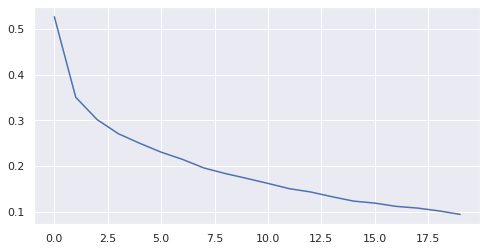

In [26]:
plt.plot(torch.arange(len(train_losses)), train_losses);

Визуализируем работу 1-ого сверточного слоя

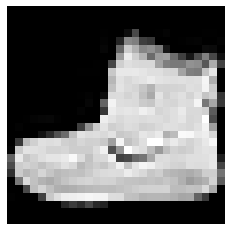

In [27]:
# входное изображение
img, target = fast_train_dataset[0]
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray");

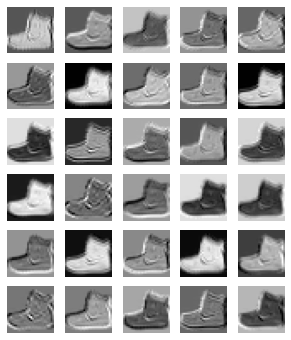

In [28]:
# изображения после свертки
first_conv_layer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
fig, axes = plt.subplots(6, 5, figsize=(5, 6))  # 6 * 5 = 30 != 32 - не покажу две картинки
for channel, ax in zip(first_conv_layer(img), axes.flatten()):
    ax.axis("off")
    ax.imshow(channel.detach(), cmap="gray")

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [29]:
_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
).data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

train_data.data.shape, len(train_data.targets), len(train_data.classes)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), 50000, 10)

In [30]:
fast_train_dataloader = FastDataloader(DataLoader(
    train_data,
    batch_size=128,
    num_workers=2 if is_colab() else 0,
))
fast_test_dataloader = FastDataloader(DataLoader(
    test_data,
    batch_size=len(test_data),
    num_workers=2 if is_colab() else 0,
))

Архитектура модели "Зачем что-то менять?" (авторское название)

In [31]:
class CIFAR10LogisticRegression(nn.Module):

    def __init__(self, in_features: int, out_features: int):
        super(CIFAR10LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_features),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.classifier(x)

In [32]:
torch.manual_seed(0)

net = CIFAR10LogisticRegression(3 * 32 * 32, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

net

CIFAR10LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

Обучаем модель:

In [33]:
%%time

epochs = 15
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(fast_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(fast_test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

Epoch 1
--------------------------------
loss: 2.304039  [    0/50000]
loss: 2.303365  [12800/50000]
loss: 2.300544  [25600/50000]
loss: 2.301232  [38400/50000]
Test Error: 
 Accuracy: 0.124900, Avg loss: 2.299535 

Epoch 2
--------------------------------
loss: 2.299495  [    0/50000]
loss: 2.298290  [12800/50000]
loss: 2.295627  [25600/50000]
loss: 2.296468  [38400/50000]
Test Error: 
 Accuracy: 0.168700, Avg loss: 2.294540 

Epoch 3
--------------------------------
loss: 2.294859  [    0/50000]
loss: 2.292843  [12800/50000]
loss: 2.290489  [25600/50000]
loss: 2.291231  [38400/50000]
Test Error: 
 Accuracy: 0.189600, Avg loss: 2.289047 

Epoch 4
--------------------------------
loss: 2.289887  [    0/50000]
loss: 2.286665  [12800/50000]
loss: 2.284590  [25600/50000]
loss: 2.285092  [38400/50000]
Test Error: 
 Accuracy: 0.208300, Avg loss: 2.282615 

Epoch 5
--------------------------------
loss: 2.284153  [    0/50000]
loss: 2.279274  [12800/50000]
loss: 2.277614  [25600/50000]
loss:

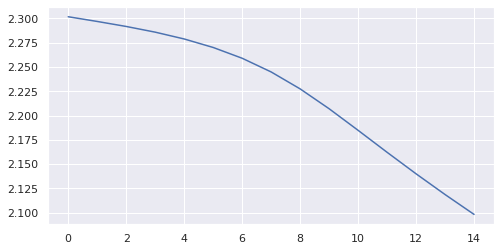

In [34]:
plt.plot(torch.arange(len(train_losses)), train_losses);

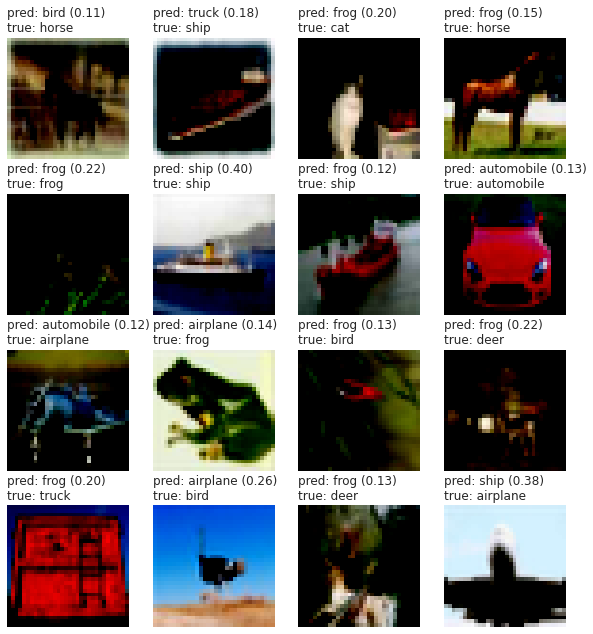

In [35]:
torch.manual_seed(0)
net.eval()

fig = plt.figure(figsize=(10, 11))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, true_label = test_data[sample_idx]

    pred = net(img.unsqueeze(0).to(DEVICE))
    pred_proba = F.softmax(pred, 1).max(1).values.item()
    pred_label = pred.argmax(1).item()

    fig.add_subplot(rows, cols, i)
    plt.title(
        f"pred: {train_data.classes[pred_label]} ({pred_proba:.2f})"
        f"\ntrue: {train_data.classes[true_label]}", loc="left"
    )
    plt.axis("off")
    # 3 x 32 x 32 [-1, 1] -> 32 x 32 x 3 [0, 1]
    plt.imshow(torch.clip(img.permute(1, 2, 0), 0, 1).cpu())

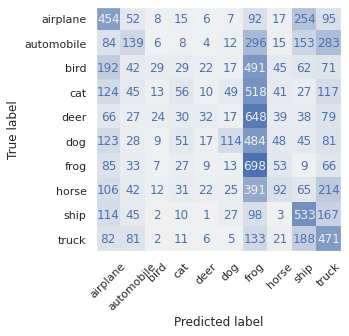

In [36]:
X_test, y_test = next(iter(fast_test_dataloader))
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
y_pred = pred.argmax(dim=1).detach()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.cpu(), y_pred.cpu(),
    display_labels=train_data.classes,
    xticks_rotation=45,
    cmap=sns.color_palette("light:b", as_cmap=True),
    colorbar=False,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(4.5, 4.5)

In [37]:
print(metrics.classification_report(y_test.cpu(), y_pred.cpu(), target_names=train_data.classes))

              precision    recall  f1-score   support

    airplane       0.32      0.45      0.37      1000
  automobile       0.26      0.14      0.18      1000
        bird       0.26      0.03      0.05      1000
         cat       0.21      0.06      0.09      1000
        deer       0.25      0.03      0.06      1000
         dog       0.40      0.11      0.18      1000
        frog       0.18      0.70      0.29      1000
       horse       0.25      0.09      0.13      1000
        ship       0.39      0.53      0.45      1000
       truck       0.29      0.47      0.36      1000

    accuracy                           0.26     10000
   macro avg       0.28      0.26      0.22     10000
weighted avg       0.28      0.26      0.22     10000



In [38]:
torch.save(net, MODELS_DIR / "CIFAR10-log-reg.pth")

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

Архитектура модели "Зачем что-то менять? 2.0" (авторское название)

In [39]:
class CIFAR10ConvNet(nn.Module):

    def __init__(self, in_channels: int, n_classes: int):
        super(CIFAR10ConvNet, self).__init__()
        self.features = nn.Sequential(OrderedDict({
            "conv1": nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            "norm1": nn.BatchNorm2d(32),
            "relu1": nn.ReLU(True),
            "maxpool1": nn.MaxPool2d(2),
            "conv2": nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            "norm2": nn.BatchNorm2d(64),
            "relu2": nn.ReLU(True),
            "maxpool2": nn.MaxPool2d(2),
        }))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(OrderedDict({
            "fc1": nn.Linear(64 * 6 * 6, 512),
            "relu1": nn.ReLU(True),
            "drop1": nn.Dropout(),
            "fc2": nn.Linear(512, 128),
            "relu2": nn.ReLU(True),
            "drop2": nn.Dropout(),
            "fc3": nn.Linear(128, n_classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [40]:
torch.manual_seed(0)

net = CIFAR10ConvNet(3, 10).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net

CIFAR10ConvNet(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=2304, out_features=512, bias=True)
    (relu1): ReLU(inplace=True)
    (drop1): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): ReLU(inplace=True)
    (drop2): Dropout(p=0.5, inplace=False)
    (fc3): Linear(in_fe

In [41]:
%%time

epochs = 20
train_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)
    train_loss = train_loop(fast_train_dataloader, net, loss_fn, optimizer)
    train_losses.append(train_loss.item())
    test_loop(fast_test_dataloader, net, loss_fn)  # смотрим на прогресс в реальном времени

Epoch 1
--------------------------------
loss: 2.306680  [    0/50000]
loss: 1.610405  [12800/50000]
loss: 1.382595  [25600/50000]
loss: 1.338286  [38400/50000]
Test Error: 
 Accuracy: 0.559300, Avg loss: 1.222586 

Epoch 2
--------------------------------
loss: 1.259854  [    0/50000]
loss: 1.186094  [12800/50000]
loss: 1.196026  [25600/50000]
loss: 1.166367  [38400/50000]
Test Error: 
 Accuracy: 0.625000, Avg loss: 1.076345 

Epoch 3
--------------------------------
loss: 1.213154  [    0/50000]
loss: 1.255053  [12800/50000]
loss: 1.178375  [25600/50000]
loss: 1.041783  [38400/50000]
Test Error: 
 Accuracy: 0.669200, Avg loss: 0.956182 

Epoch 4
--------------------------------
loss: 0.880124  [    0/50000]
loss: 0.993476  [12800/50000]
loss: 1.066285  [25600/50000]
loss: 1.019309  [38400/50000]
Test Error: 
 Accuracy: 0.673500, Avg loss: 0.922606 

Epoch 5
--------------------------------
loss: 0.758140  [    0/50000]
loss: 0.955526  [12800/50000]
loss: 1.029451  [25600/50000]
loss:

In [42]:
X_test, y_test = next(iter(fast_test_dataloader))
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

pred = net(X_test)
pred_proba = torch.max(F.softmax(pred, dim=1), dim=1)
y_pred = pred.argmax(dim=1).detach()

print(metrics.classification_report(y_test.cpu(), y_pred.cpu(), target_names=train_data.classes))

              precision    recall  f1-score   support

    airplane       0.80      0.81      0.80      1000
  automobile       0.79      0.93      0.86      1000
        bird       0.80      0.60      0.68      1000
         cat       0.54      0.67      0.60      1000
        deer       0.82      0.65      0.72      1000
         dog       0.74      0.60      0.66      1000
        frog       0.84      0.83      0.84      1000
       horse       0.77      0.84      0.80      1000
        ship       0.88      0.85      0.86      1000
       truck       0.74      0.86      0.80      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



In [43]:
torch.save(net, MODELS_DIR / "CIFAR10-cnn.pth")

In [44]:
if is_colab(DEVICE):
    !zip -r / content / models.zip / content / models
    from google.colab import files

    files.download("/content/models.zip")

  adding: content/models/ (stored 0%)
  adding: content/models/CIFAR10-cnn.pth (deflated 7%)
  adding: content/models/FashionMNIST-log-reg.pth (deflated 8%)
  adding: content/models/CIFAR10-log-reg.pth (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Вывод:** не изменив ни одного параметра модели FashionMNSITConvNet я получил удовлетворительный результат для другой задачи.